<a href="https://colab.research.google.com/github/deivispuertas/medical_cost_predict/blob/main/proyecto_ETL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresión lineal: predecir los gastos médicos de pacientes
---

Para este ejercicio utilizaremos los datos presentados en [este](https://www.kaggle.com/mirichoi0218/insurance) dataset de Kaggle en el cual se presentan datos de seguros médicos.


## Descarga e instalación de librerías

Lo primero que se hará es descargar la librería **[regressors](https://pypi.org/project/regressors/)** que ayudará a hacer un análisis más profundo sobre la regresión lineal.

!pip install regressors actualmente para la versiones de python y otras mas, no es posible descargarlo se necesita cambiar versiones de paquetes por ello utilizaremos otra libreria que seria scikit-learn


In [34]:
# !pip install regressors

In [35]:
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid', context='notebook')

## Descargando los datos
Descarguemos los datos y veamos cómo se ven.

In [36]:
df = pd.read_csv('insurance.csv')
df.head()

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

## Analizando los datos
Se observará cómo se distribuyen los datos de la variable a predecir.

(1338, 7)


<Axes: >

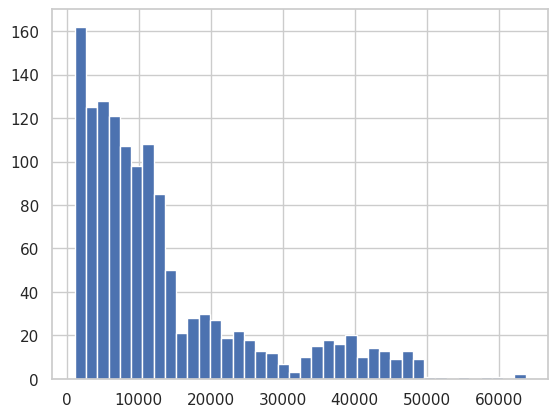

In [37]:
print(df.shape)
df.charges.hist(bins=40)

Algo que analizar, según este gráfico, es entender qué está pasando con los datos arriba de los 50,000. Parece haber muy pocos datos de este lado.

In [38]:
df[df.charges>50000]

age     sex     bmi  children smoker     region      charges
34     28    male  36.400         1    yes  southwest  51194.55914
543    54  female  47.410         0    yes  southeast  63770.42801
577    31  female  38.095         1    yes  northeast  58571.07448
819    33  female  35.530         0    yes  northwest  55135.40209
1146   60    male  32.800         0    yes  southwest  52590.82939
1230   52    male  34.485         3    yes  northwest  60021.39897
1300   45    male  30.360         0    yes  southeast  62592.87309

In [39]:
df = df[df.charges<50000]

En este caso, al ser pocos datos (6 de 1338), eliminaremos estos datos atípicos. A modo didáctico producen más ruido en la predicción que se está intentando hacer en este ejercicio.

Sin embargo es importante aclarar que **NO SE DEBEN ELIMINAR** datos atípicos sin antes conocer a alguien que conozca o sea experto en los datos para que pueda guiarnos mejor sobre ellos.

## Viendo correlaciones
Ahora entendamos nuestros datos, viendo cómo se distribuyen y correlacionan.

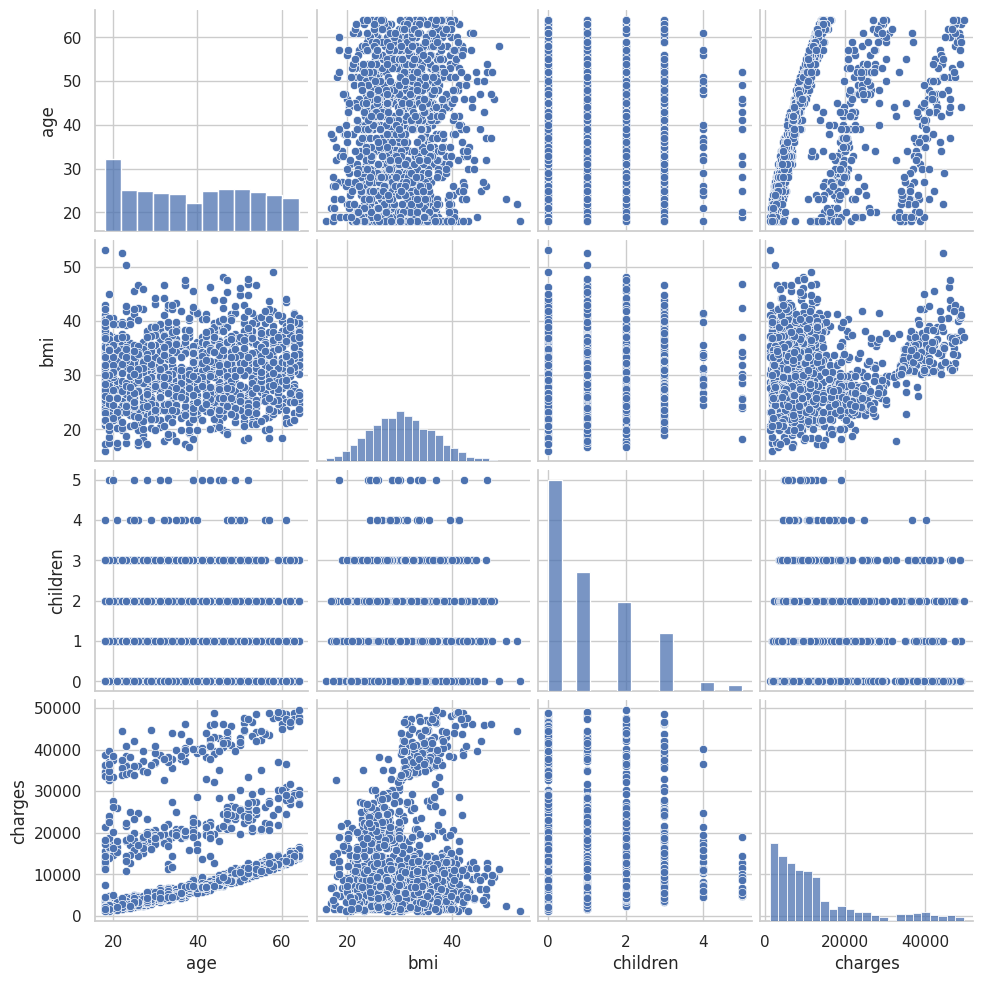

In [40]:
import matplotlib.pyplot as plt
sns.pairplot(df, height=2.5)
plt.show()

Puntos interesantes a ver:

- Hay 3 grupos de personas diferentes que se clasifican en edad / cargos, esto puede ser un punto a analizar después.

En general los valores se distribuyen de manera esperada. Con valores extremos en el caso de los cargos, sin embargo esto es de esperarse pues los cargos en los hospitales pueden variar mucho por quedarse un día más en el hospital o incluso por procedimientos extras.

- Parece que los datos están limpios, la variable de índice de masa corporal se distribuye de manera normal o gausiana, lo cual sería esperado en un índice de este tipo.

<Axes: >

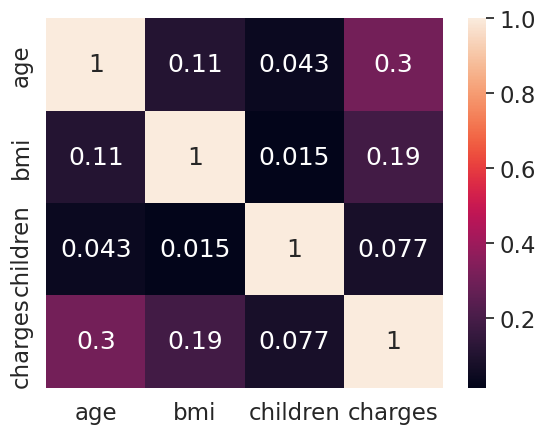

In [41]:
import numpy as np
numeric_cols = ['age', 'bmi', 'children', 'charges']
cm = np.corrcoef(df[numeric_cols].values.T)
sns.set(font_scale=1.5)
sns.heatmap(cm, annot=True, yticklabels=numeric_cols, xticklabels=numeric_cols)

## Utilizando las demás variables
Las demás variables son variables categoricas, sexo, fumador, región. Para poder utilizarlas utilizaremos la función get_dummies de pandas.

Ahora la verás en acción

In [42]:
df = pd.get_dummies(df, columns = ['sex', 'smoker', 'region'], drop_first=True)
df.head()

age     bmi  children      charges  sex_male  smoker_yes  region_northwest  \
0   19  27.900         0  16884.92400     False        True             False   
1   18  33.770         1   1725.55230      True       False             False   
2   28  33.000         3   4449.46200      True       False             False   
3   33  22.705         0  21984.47061      True       False              True   
4   32  28.880         0   3866.85520      True       False              True   

   region_southeast  region_southwest  
0             False              True  
1              True             False  
2              True             False  
3             False             False  
4             False             False

## Creando modelos
Primero se usará un modelo con todas las variables.

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [44]:
X_cols = list(set(df.columns) - set(['charges']))
y_col = df['charges']

X = df[X_cols].values
y = y_col.values

X_train, X_test, y_train, y_test = train_test_split(X, y)
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y.reshape(-1, 1))

X_train = sc_x.fit_transform(X_train)
X_test = sc_x.transform(X_test)

y_train = sc_y.fit_transform(y_train.reshape(-1,1))
y_test = sc_y.transform(y_test.reshape(-1,1))

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [45]:
y_pred.shape

(333, 1)

## Funciones de métricas
El siguiente punto es calcular las métricas del modelo.

In [46]:
import sklearn.metrics as metrics
mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
print(f'R2: {round(r2, 4)}')
print(f'MSE: {round(mse, 4)} ')

R2: 0.7825
MSE: 0.232 


El siguiente código muestra un resumen general de los resultados.

In [47]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

# Asegurar que X_test tiene una constante (intercepto)
X_test_const = sm.add_constant(X_test)

# Crear el modelo OLS con statsmodels
ols_model = sm.OLS(y_test, X_test_const).fit()

# Mostrar el resumen del modelo
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     153.7
Date:                Mon, 24 Feb 2025   Prob (F-statistic):          1.87e-105
Time:                        20:40:22   Log-Likelihood:                -222.25
No. Observations:                 333   AIC:                             462.5
Df Residuals:                     324   BIC:                             496.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0241      0.026      0.918      0.3

Finalmente tenemos la función que calcula los residuales. Es importante notar que es una simple resta entre los valores reales y los predichos.

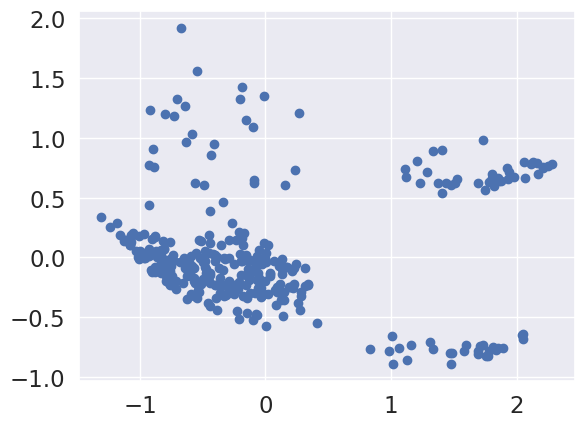

In [51]:
residuals = np.subtract(y_test, y_pred)
plt.scatter(y_pred, residuals)
plt.show()


## Segundo modelo
Estos resultados de arriba son buenos, pero se pueden mejorar. Intentaremos hacer algunas transformaciones sobre las variables que pueden ser de utilidad.

In [53]:
df_second = df.copy()
df_second['age2'] = df_second.age**2
df_second['sobrepeso'] = (df_second.bmi >= 30).astype(int)
df_second['sobrepeso*fumador'] = df_second.sobrepeso * df_second.smoker_yes

Analizando el segundo modelo

In [68]:
# Definir las columnas de entrada y salida
x_cols = ['sobrepeso*fumador', 'smoker_yes', 'age2', 'children']
y_col = ['charges']

# Obtener los valores de las variables independientes y dependientes
X = df_second[x_cols].values
y = df_second[y_col].values

# Dividir en datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos
sc_x = StandardScaler().fit(X_train)
sc_y = StandardScaler().fit(y_train)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)

y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression(fit_intercept= False)
model.fit(X_train, y_train)

# Predecir valores
y_pred = model.predict(X_test)


In [69]:
import sklearn.metrics as metrics
mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
print(f'R2: {round(r2, 4)}')
print(f'MSE: {round(mse, 4)} ')

R2: 0.8944
MSE: 0.1281 


In [70]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

# Asegurar que X_test tiene una constante (intercepto)
X_test_const = sm.add_constant(X_test)

# Crear el modelo OLS con statsmodels
ols_model = sm.OLS(y_test, X_test_const).fit()

# Mostrar el resumen del modelo
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     580.0
Date:                Mon, 24 Feb 2025   Prob (F-statistic):          8.00e-129
Time:                        21:00:51   Log-Likelihood:                -99.148
No. Observations:                 267   AIC:                             208.3
Df Residuals:                     262   BIC:                             226.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0110      0.022     -0.503      0.6

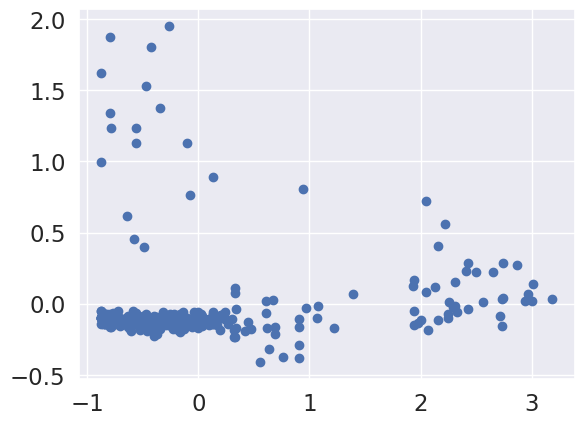

In [71]:
residuals = np.subtract(y_test, y_pred)
plt.scatter(y_pred, residuals)
plt.show()
